In [1]:
import scrapy

## 기존 프로젝트 삭제
- **remove_all.sh** Shell script 실행
- **remove_all.sh**
    - 이미 만든 프로젝트가 있는지 확인하고 있으면 관련된 디렉터리 및 파일 모두 삭제

In [33]:
!sh remove_all.sh

Prior Project removed
Ready to create New Porject


## 새로운 프로젝트 생성
- **naver_movie_reply** 프로젝트 생성

In [3]:
!scrapy startproject naver_movie_reply

New Scrapy project 'naver_movie_reply', using template directory '/usr/local/lib/python3.7/site-packages/scrapy/templates/project', created in:
    /Users/vincent_geranium/Desktop/naver_crawling_scrapy (1)/naver_movie_reply

You can start your first spider with:
    cd naver_movie_reply
    scrapy genspider example example.com


## Item 클래스 생성
- **NaverMovieReplyItem**
    - 영화 댓글 정보를 담을 클래스
        - content : 댓글 내용 
        - star : 평점
        - sympathy : 공감수
        - notsympathy : 비공감수
- **NaverMovieItem**
    - 영화 정보를 담을 클래스
        - title : 영화 제목
        - star : 평점
        - code : 영화의 고유한 코드

In [4]:
%%writefile naver_movie_reply/naver_movie_reply/items.py
import scrapy

class NaverMovieReplyItem(scrapy.Item):
    content = scrapy.Field()
    star = scrapy.Field()
    sympathy = scrapy.Field()
    notsympathy = scrapy.Field()

    
class NaverMovieItem(scrapy.Item):
    title = scrapy.Field()
    star = scrapy.Field()
    code = scrapy.Field()

Overwriting naver_movie_reply/naver_movie_reply/items.py


## Spider 클래스 생성
- **MovieSpider**
    - 사용자가 입력한 검색어와 관련된 영화 목록을 crawling 하는 Spider
- **MovieReplySpider**
    - 영화 목록 중 사용자가 선택한 영화의 댓글을 crawling 하는 Spider

### MovieSpider

In [5]:
%%writefile naver_movie_reply/naver_movie_reply/spiders/movie_spider.py
import scrapy
from naver_movie_reply.items import NaverMovieItem
import re

class MovieSpider(scrapy.Spider):
    # spider의 이름
    name = "NaverMovie"
    # spider의 crawling 허용 도메인
    allow_domain = ["https://movie.naver.com"]

    # spider의 최초 리퀘스트
    # 영화 검색
    # 사용자가 입력한 검색어를 파라미터(self.keyword)로 받아 url 파라미터 중 query 부분에 삽입하여 리퀘스트
    def start_requests(self):
        yield scrapy.Request(url='https://movie.naver.com/movie/search/result.nhn?query={}&section=all&ie=utf8'\
                             .format(self.keyword), callback=self.parse)
    
    # 검색 된 영화 목록 페이지 별로 리퀘스트 
    def parse(self, response):
        # 검색된 영화 목록의 총 개수 추출
        count_movie = response.xpath('//*[@id="old_content"]/div[1]/span/text()')\
                                     .extract()[0].split("/")[1].strip()[:-2]
        # 검색된 영화의 '더 많은 영화보기' 목록의 페이지 수
        # 각 페이지 마다 영화 목록 10개가 비치됨
        count_page = int(count_movie) // 10\
                     if int(count_movie) % 10 == 0 else int(count_movie) // 10 + 1
        # '더 많은 영화보기' 목록 페이지의 url 추출(이 url 뒤에 &page={}를 추가하여 리퀘스트)
        # 검색된 영화 개수가 5개를 초과해야 존재함
        url = response.xpath('//*[@id="old_content"]/a[1]/@href').extract()[0]
        
        # 검색된 영화 목록의 총 개수가 5개 이하일 경우는 현재 reponse를 이용하여 파싱 가능
        # 이때의 파싱 동작은 아래 item_parse와 동일하여 item_parse를 이용하려 했지만 동작하지 않음
        if int(count_movie) <= 5:
            # 영화 목록 추출
            movies = response.xpath('//*[@id="old_content"]/ul[2]/li')
            # 영화 별 파싱
            for movie in movies:
                item = NaverMovieItem()
                # 영화 제목 부분 추출
                title = movie.xpath('./dl/dt/a').extract()[0]
                # 영화 제목 부분 내 html 태그 제거하여 영화 제목만 추출 및 item 에 삽입
                item["title"] = re.sub('<[^<>]+>', '', title)
                # 영화 평점 추출 및 item에 삽입
                item["star"] = movie.xpath('./dl/dd[1]/em[1]/text()').extract()[0]
                # 영화 코드 추출 및 item에 삽입
                item["code"] = movie.xpath('./dl/dt/a/@href').extract()[0].split("=")[1].strip()
                yield item
        # '더 많은 영화보기' 목록 페이지가 존재하는 경우
        else:
            url = response.urljoin(url)
            # 각 '더 많은 영화보기' 목록 페이지의 url에 리퀘스트
            for i in range(1, count_page + 1):
                yield scrapy.Request(url=url+'&page={}'.format(i), callback=self.item_parse)
    
    # 각 '더 많은 영화보기' 목록 페이지 내 영화 정보 추출
    # 함수 동작은 영화 목록이 5개 이하인 경우와 동일
    def item_parse(self, response):
        movies = response.xpath('//*[@id="old_content"]/ul[2]/li')
        for movie in movies:
            item = NaverMovieItem()
            title = movie.xpath('./dl/dt/a').extract()[0]
            item["title"] = re.sub('<[^<>]+>', '', title)
            item["star"] = movie.xpath('./dl/dd[1]/em[1]/text()').extract()[0]
            item["code"] = movie.xpath('./dl/dt/a/@href').extract()[0].split("=")[1].strip()
            yield item

Writing naver_movie_reply/naver_movie_reply/spiders/movie_spider.py


### MovieReplySpider

In [6]:
%%writefile naver_movie_reply/naver_movie_reply/spiders/movie_reply_spider.py
import scrapy
from naver_movie_reply.items import NaverMovieReplyItem

class MovieReplySpider(scrapy.Spider):
    # spider의 이름
    name = "NaverMovieReply"
    # spider의 crawling 허용 도메인
    allow_domain = ["https://movie.naver.com"]

    # spider의 최초 리퀘스트
    # 사용자가 선택한 영화 검색
    # 사용자가 선택한 영화의 code를 파라미터(self.code)로 받아 url 파라미터 중 code 부분에 삽입하여 리퀘스트
    def start_requests(self):
        yield scrapy.Request(url='https://movie.naver.com/movie/bi/mi/basic.nhn?code={}'\
                             .format(self.code), callback=self.parse)
    
    # 해당 영화의 댓글 페이지 별로 리퀘스트
    def parse(self, response):
        # 해당 영화의 댓글 수 추출
        try:
            count_reply = response.xpath('//*[@class="score_total"]/strong/em/text()')\
                                         .extract()[0].strip().replace(",", "")
        # 해당 영화의 댓글 수가 0이면 Exception 발생
        # 댓글 페이지 수를 0으로 설정
        except Exception:
            count_page = 0
        # 해당 영화의 댓글 수가 1 이상이면 댓글 페이지 수 계산
        else:
            count_page = int(count_reply) // 10\
                         if int(count_reply) % 10 == 0 else int(count_reply) // 10 + 1
        # 각 댓글 페이지 마다 리퀘스트
        for i in range(1, count_page + 1):
            yield scrapy.Request(url='https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?\
code={}&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false\
&isMileageSubscriptionReject=false&page={}'.format(self.code, i), callback=self.item_parse)

    # 댓글 페이지 내 댓글 파싱
    def item_parse(self, response):
        # 댓글 페이지 내 댓글 목록 추출
        replys = response.xpath('/html/body/div/div/div[6]/ul/li')
        # 댓글 별 파싱
        for reply in replys:
            item = NaverMovieReplyItem()
            # 평점 추출 및 item 에 삽입
            item["star"] = reply.xpath('./div[1]/em/text()').extract()[0]
            # 내용 추출 및 item에 삽입
            item["content"] = reply.xpath('./div[2]/p/text()').extract()[0].strip()
            # 공감수 추출 및 item에 삽입
            item["sympathy"] = reply.xpath('./div[3]/strong[1]/span/text()').extract()[0]
            # 비공감수 추출 및 item에 삽입
            item["notsympathy"] = reply.xpath('./div[3]/strong[2]/span/text()').extract()[0]
            yield item

Writing naver_movie_reply/naver_movie_reply/spiders/movie_reply_spider.py


## Pipeline 클래스 생성 생성
- **NaverMovieReply** Spider는 **naver_movie_reply.csv** 생성
- **NaverMovie** Spider는 **naver_movie.csv** 생성

In [7]:
%%writefile naver_movie_reply/naver_movie_reply/pipelines.py
import csv

class NaverMovieReplyPipeline(object):
    # spider가 시작 될때 실행되는 메서드
    def open_spider(self, spider):
        # spider가 NaverMovieReply 일 경우 naver_movie_reply.csv 생성
        if spider.name == "NaverMovieReply":
            self.csvwriter = csv.writer(open("naver_movie_reply.csv", "w", encoding="utf-8"))
            self.csvwriter.writerow(["평점", "댓글", "공감수", "비공감수"])
        # spider가 NaverMovie 일 경우 naver_movie.csv 생성
        else:
            self.csvwriter = csv.writer(open("naver_movie.csv", "w", encoding="utf-8"))
            self.csvwriter.writerow(["코드", "제목", "평점"])
    
    # spider에서 item이 생성될 때 실행되는 메서드
    def process_item(self, item, spider):
        row = []
        # NaverMovieReply의 item일 경우
        # naver_movie_reply.csv에 아이템 삽입
        if spider.name == "NaverMovieReply":
            row.append(item["star"])
            row.append(item["content"])
            row.append(item["sympathy"])
            row.append(item["notsympathy"])
        # NaverMovie의 item일 경우
        # naver_movie.csv에 아이템 삽입
        else:
            row.append(item["code"])
            row.append(item["title"])
            row.append(item["star"])
        self.csvwriter.writerow(row)
        return item

Overwriting naver_movie_reply/naver_movie_reply/pipelines.py


## Settings 설정
- ROBOTSTXT_OBEY = **True** => ROBOTSTXT_OBEY = **False**
- Pipeline 사용 설정

In [8]:
!sed -i'.bak' 's/ROBOTSTXT_OBEY = True/ROBOTSTXT_OBEY = False/' naver_movie_reply/naver_movie_reply/settings.py

In [9]:
!echo ITEM_PIPELINES = { >> naver_movie_reply/naver_movie_reply/settings.py

- linux의 경우에는 첫번 째 shell 명령어를 사용
- windows의 경우에는 두번 째 shell 명령어를 사용

In [10]:
!echo     \'naver_movie_reply.pipelines.NaverMovieReplyPipeline\': 300, >> naver_movie_reply/naver_movie_reply/settings.py
# !echo     'naver_movie_reply.pipelines.NaverMovieReplyPipeline': 300, >> naver_movie_reply/naver_movie_reply/settings.py

In [11]:
!echo } >> naver_movie_reply/naver_movie_reply/settings.py

## 영화 제목 검색

In [12]:
from urllib import parse
movie_name = parse.quote(input("영화제목을 입력해주세요 : "))

영화제목을 입력해주세요 : 해리포터


## 영화 검색 Spider 실행 Shell Script 생성

In [13]:
!echo cd naver_movie_reply >> run_movie.sh

In [14]:
!echo scrapy crawl NaverMovie -a keyword={movie_name} >> run_movie.sh

## 영화 검색 Spider 실행 Shell Script 실행

In [15]:
!sh run_movie.sh

2018-11-08 09:56:58 [scrapy.utils.log] INFO: Scrapy 1.5.1 started (bot: naver_movie_reply)
2018-11-08 09:56:58 [scrapy.utils.log] INFO: Versions: lxml 4.2.5.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.0, w3lib 1.19.0, Twisted 18.9.0, Python 3.7.0 (default, Aug 22 2018, 15:22:33) - [Clang 9.1.0 (clang-902.0.39.2)], pyOpenSSL 18.0.0 (OpenSSL 1.1.0i  14 Aug 2018), cryptography 2.3.1, Platform Darwin-18.2.0-x86_64-i386-64bit
2018-11-08 09:56:58 [scrapy.crawler] INFO: Overridden settings: {'BOT_NAME': 'naver_movie_reply', 'NEWSPIDER_MODULE': 'naver_movie_reply.spiders', 'SPIDER_MODULES': ['naver_movie_reply.spiders']}
2018-11-08 09:56:58 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2018-11-08 09:56:58 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 'sc

## 원하는 영화 선택

In [16]:
df = pd.read_csv("naver_movie_reply/naver_movie.csv")
df[["제목", "평점"]]

,제목,평점
0,해리 포터와 마법사의 돌 (Harry Potter And The Sorcerer's...,9.22
1,해리 포터와 죽음의 성물 - 2부 (Harry Potter And The Death...,9.31
2,해리 포터와 아즈카반의 죄수 (Harry Potter And The Prisoner...,8.66
3,해리 포터와 비밀의 방 (Harry Potter And The Chamber Of ...,8.85
4,해리 포터와 죽음의 성물 - 1부 (Harry Potter And The Death...,8.20
5,해리 포터와 불의 잔 (Harry Potter And The Goblet Of Fire),7.94
6,해리 포터와 혼혈 왕자 (Harry Potter And The Half-Blood ...,6.84
7,해리 포터와 불사조 기사단 (Harry Potter And The Order Of ...,6.97
8,해리 포터 주차장 (Harry Potter Parking Lot),9.13


In [17]:
movie_index = int(input("영화를 선택해주세요(0~" + str(len(df) - 1) + ") : "))

영화를 선택해주세요(0~8) : 0


In [18]:
movie_code = df.loc[movie_index, "코드"]
movie_code

30688

## 영화 댓글 Spider 실행 Shell Script 생성

In [19]:
!echo cd naver_movie_reply >> run_movie_reply.sh

In [20]:
!echo scrapy crawl NaverMovieReply -a code={movie_code} >> run_movie_reply.sh

## 영화 댓글 Spider 실행 Shell Script 실행

In [21]:
!sh run_movie_reply.sh

2018-11-08 09:57:06 [scrapy.utils.log] INFO: Scrapy 1.5.1 started (bot: naver_movie_reply)
2018-11-08 09:57:06 [scrapy.utils.log] INFO: Versions: lxml 4.2.5.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.0, w3lib 1.19.0, Twisted 18.9.0, Python 3.7.0 (default, Aug 22 2018, 15:22:33) - [Clang 9.1.0 (clang-902.0.39.2)], pyOpenSSL 18.0.0 (OpenSSL 1.1.0i  14 Aug 2018), cryptography 2.3.1, Platform Darwin-18.2.0-x86_64-i386-64bit
2018-11-08 09:57:06 [scrapy.crawler] INFO: Overridden settings: {'BOT_NAME': 'naver_movie_reply', 'NEWSPIDER_MODULE': 'naver_movie_reply.spiders', 'SPIDER_MODULES': ['naver_movie_reply.spiders']}
2018-11-08 09:57:06 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2018-11-08 09:57:06 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 'sc

2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=39> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=42> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=35>
{'content': '다시봐도 너무 좋네요!', 'notsympathy': '1', 'star': '10', 'sympathy': '2'}
2018-11-08 

2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=38>
{'content': '끄어어어어어~~!!!!진짜진짜 싸랑해요!!!!',
 'notsympathy': '1',
 'star': '10',
 'sympathy': '2'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=38>
{'content': '해리포터의 시작은 3편 부터 시작. 1,2편은 맛보기',
 'notsympathy': '1',
 'star': '6',
 'sympathy': '2'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=38>
{'content': '주인공들이 당시에는 참 사랑스러웠고,

2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=298> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=297> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=296> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07

2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=32>
{'content': '와 진짜 이거 예전에 너무 재밌게 봤었는데 시간날 때 비디오로 시리즈 모두 빌려서 다시 봤었지...',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '1'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=32>
{'content': '신세계!!!', 'notsympathy': '0', 'star': '10', 'sympathy': '1'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=32>
{'content': '내심장을뛰게한영화이다', '

2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=92>
{'content': '모든건 이날 시작되었다', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=92>
{'content': '어렸을 적엔 아주 그냥 최고의 영화',
 'notsympathy': '0',
 'star': '8',
 'sympathy': '0'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=92>
{'content': 'this very fun', 'notsympathy': '0', 'star': '1

2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=296>
{'content': '이건 아니지??? 재개봉은 무슨???',
 'notsympathy': '16',
 'star': '2',
 'sympathy': '3'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=296>
{'content': '상상력은 좋으나..다분히 어린이용',
 'notsympathy': '14',
 'star': '1',
 'sympathy': '0'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=296>
{'content': '역시책이최고지 개뼉따구같은캐스팅,-_-다니엘엠마',
 'n

2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=280> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=279> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=294>
{'content': '영화로볼때보가 책으로 보니까 살짝 어려워서 별로였다',
 'notsympathy': '9',
 'star': '1',
 'sympat

2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=289>
{'content': '아직까진 귀엽기만한 마법', 'notsympathy': '3', 'star': '5', 'sympathy': '0'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=289>
{'content': '그 당시에 봤으면 신선했을텐데..',
 'notsympathy': '3',
 'star': '5',
 'sympathy': '0'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=289>
{'content': '1편은 별로....', 'notsympathy': '3', 'star': '5'

2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=275> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=274> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=273> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07

2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=280>
{'content': '개인적으로 해리포터는 영화나 소설이나 맘에 안든다',
 'notsympathy': '1',
 'star': '5',
 'sympathy': '0'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=280>
{'content': '책을 그대로 살리지 못한것은 아쉽다',
 'notsympathy': '1',
 'star': '6',
 'sympathy': '0'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=280>
{'content': '괜찮긴한데, 책을먼저 봐서 그런지... 너무 듬

2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=265> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=264> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=263> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07

2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=276>
{'content': '꽤 괜찮았던 작품', 'notsympathy': '1', 'star': '8', 'sympathy': '0'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=276>
{'content': '역시 책을 능가할 수는 없단 말인가?',
 'notsympathy': '1',
 'star': '7',
 'sympathy': '0'}
2018-11-08 09:57:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=276>
{'content': '너무 많이 잘라먹은 것 같다.',
 'notsympathy': '1',
 'star

2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=261> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=260> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=259> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:07

2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=265>
{'content': '저 또한 전설의 시작이라 생각합니다',
 'notsympathy': '1',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=265>
{'content': '적어도 내겐 해리포터를 능가하는 판타지소설과 영화는  앞으로 나오지 않을 것이다',
 'notsympathy': '1',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=265>
{'content': '진짜 짱이다 

2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=251> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=250> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=249> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08

2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=255>
{'content': '해리포터 짱! 정말 재밌어요!',
 'notsympathy': '1',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=255>
{'content': '알버스 덤블도어...ㅠㅠ', 'notsympathy': '1', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=255>
{'content': '요요여요여ㅕ여여여ㅕㅇ', 'notsympathy': '1', 'star': '1

2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=241> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=240> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=239> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08

2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=251>
{'content': '저는 sf나판타지에 별관심이 없었는데 해리포터덕분에 소설읽기를좋아하게되고 책을많이읽게되고 이중에서 제일큰것은 그 '
            '장르를 좋아하게되고 해리포터를 좋아하게됬죠 작가님 사랑합니다 조앤 롤링작가님 해리포터 짱 《해리포터 덕후인 어느 '
            '소녀》 출연진들 짱임진짜루',
 'notsympathy': '2',
 'star': '10',
 'sympathy': '2'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=251>
{'content': '정주행 할려고 오랜만에 4번째 보는건데 그냥 넘사벽 영화. 말이 필요없음. 그나저나 꼬맹이 3인방 연기 개잘하네 '
            '지금봐도 ㅋㅋ',
 'notsympathy': '2',
 'star': '10',
 'sympathy': '2'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.

2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=237> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=236> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=235> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08

2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=240>
{'content': '재밌어요-0-', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=240>
{'content': '해리포터너무 재밌구요, 빨리영화나왔으면좋겟어요.해리포터넘멋져요~!♡',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=240>
{'content': '재밌어엽~!~!^^', 'notsympathy': '

2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=225> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=224> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=223> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08

2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=235>
{'content': '너무 재밌는데 + ㅁ+!', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=235>
{'content': '안녕하슈 저는 청천도사람이유',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=234>
{'content': '너무나 재미난영하', 'notsympathy': '0', 'star': '10',

2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=221> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=220> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=219> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08

2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=223>
{'content': '신기함,호기심 으로 바라본 영화,',
 'notsympathy': '0',
 'star': '8',
 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=223>
{'content': '해리포터시리즈중최고였음~가면갈수록엉망이되가지만-_-..',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=223>
{'content': '그냥재밌네..', 'notsympathy'

2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=206> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=221>
{'content': '재밌었어여', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=221>
{'content': '퀴디치 게임 재미있게 봤어요~',
 'notsympathy': '0',
 'star': '9',
 'sympathy': '0'

2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=216>
{'content': '해리포터재미있음 ㅎ', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=216>
{'content': '왜 이제서야 본건가ㅜㅜ..시간가는줄 몰랐음',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=216>
{'content': '넘,넘재미있다...', 'notsympathy': '0', 'star':

2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=200> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=199> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=198> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:08

2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=209>
{'content': '마법사의돌,비밀의방이 최고다..다른거는....',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=209>
{'content': '상상의나라로 ㅋㅋㅋㅋ', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=209>
{'content': '넘 재밋어요', 'notsympathy': '0', 'star': 

2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=193> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=192> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=191> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09

2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=202>
{'content': '2001년 중1학년때,,ㅋ친구셋이서 극장가서봤었는데 완전 기억난다',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=201>
{'content': '재미는 모르겠고 다니엘이 너무 귀여웠기 때문에..ㅋㅋ',
 'notsympathy': '0',
 'star': '9',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=201>
{'content': '책으로도 한

2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=186> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=185> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=184> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09

2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=195>
{'content': '5년전에 봤지만 그떄의 재미만큼 지금도 후회안함 하지만 지루함여전',
 'notsympathy': '0',
 'star': '9',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=195>
{'content': '영화 해리포터는 마법사의 돌이 최고였다. 음 책도 최고였어',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=195>
{'content': '해리포

2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=179> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=178> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=177> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09

2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=188>
{'content': '해리포터시리즈를 알게해준 영화',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=187>
{'content': '다시봐도 재미있는 정말 귀엽구나',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=187>
{'content': '솔직히 해리포터 세계에선 최고중하나로인정받음;한국인이란 ㅉㅉ;',


2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=173> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=172> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=171> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09

2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=174>
{'content': '폿허야!!!', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=174>
{'content': '마법사의돌만 진짜 해리포터 시리즈',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=174>
{'content': '시리즈중 영화상에선 젤 잼있었던 영화^^',
 'notsympathy': '0',
 's

2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=167>
{'content': '완젼...판타지의 최고봉??!',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=167>
{'content': '정말 정말 재밌음 재밌음!!',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=167>
{'content': '재밌어요', 'notsympathy': '0', 'star': '10'

2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=159>
{'content': '어린애들이나대긴하지만 어린애들이 하는영화는긴장감없던데 이건 예외',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=159>
{'content': '엄청 재밌고 세상에서 제가 본영화중에서는 1위로선정 완전 초대박 재밌음',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=159>
{'content

2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=142> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=157>
{'content': '완전 재미요~!! 화려한 영상들과~ 그래픽들..!! 너무 멋집니다..',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=157>
{'content': '느그들이 이거찍어바', 'notsympathy': '0', '

2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=152>
{'content': '저요 이 해리포터 시리즈 광팬~ 이에요~~ 재미있게 보앗어요 ㅇㅅㅇ',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=152>
{'content': '완전짱!!', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=152>
{'content': '재미있는 편!!!', 'notsympathy': '0',

2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=136> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=135> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=134> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09

2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=145>
{'content': '너무 재밌는 영화><디브이디로 보면 게임(?)도 있어요!>',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=145>
{'content': '최고의 판타지 영화', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=145>
{'content': '해리포터 최고!! 너무 재미있어요!!',
 'notsym

2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=129> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=128> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=127> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:09

2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=138>
{'content': '마법', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=138>
{'content': '카트를 밀고 9와 3/4 승강장을 통과하던 포터의 모습을 잊을 수 없을 듯...',
 'notsympathy': '0',
 'star': '8',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=138>
{'content': '짱재밌음...', 'notsympathy': '0'

2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=123> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=122> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=121> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10

2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=130>
{'content': '어렸을때 정말 재미있게 보았던 영화 ! ㅇㅂㅇ',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=130>
{'content': '1편이 가장 재밌었다. 아아~세월이여.',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=129>
{'content': '정말 말이 필요없습니다.ㅎㅎ 별이 다섯개!!

2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=114> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=113> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=112> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10

2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=123>
{'content': '해리포터 시리즈 중에서 젤 잘만든거임 ㅋㅋㅋ',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=123>
{'content': '살짝 유치하고 아역들의 연기가 좀 떨어진다. 그래도 잊을수 없는 교훈을 주었다',
 'notsympathy': '0',
 'star': '8',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=122>
{'content': '8살때 

2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=107> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=106> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=105> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10

2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=115>
{'content': '이때 참 달달헀지~', 'notsympathy': '0', 'star': '9', 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=115>
{'content': '이게 레알 짜세임 ㅇㅇ', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=115>
{'content': '정말로 명작임 이건', 'notsympathy': '0', 'star': '10', 'sympath

2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=100> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=99> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=98> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [

2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=93> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=91> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=90> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [s

2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=94>
{'content': '해리 포터 는 정말걸작이죠.. 식을줄모르는 인기',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=94>
{'content': '아 위대한 소설 위대한 영화 ㅎㅎ',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=94>
{'content': '해리포터전권다사서하루에한권씩읽고있음ㅋㅋㅋㅋㅋㅋ완전재밌

2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=86>
{'content': '해리포터시리즈중 제일깔끔하다.',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=86>
{'content': '그 시절엔 새로웠으며 지금은 추억이 된 영화',
 'notsympathy': '0',
 'star': '8',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=86>
{'content': '그 시절엔 새로웠으며 지금은 추억이 된 영화',
 'notsy

2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=69> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=84>
{'content': '어린시절 추억의 영화 레드클리프가 큰만큼 나도 자랐구나',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=84>
{'content': '초등학교 1학년때 영화보고 바로 시리즈별로 나온거 다사서 일주일만에 다 읽었던 기

2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=79>
{'content': '해리포터 안본 뇌 삽니다☆☆☆☆',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=79>
{'content': '판타지 영화의 지존은 역시 해리포터!',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=79>
{'content': '와나아마 한편당2번씩은훨신넘게본듯진심계속봐도안질림',
 'nots

2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=63> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=62> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=61> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:10 [s

2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=71>
{'content': '아직도 헤리포터의 ost를 들으면 가슴이 막 뛴다내가 왜 작가가 돼고싶은지에 이유를 알려준 소설이자 영화',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=71>
{'content': '해리포터, 반지의제왕, 라이온킹, 인디아나존스, 배트맨 시리즈...내겐 평생 잊을수 없고 몇번이고 다시볼 '
            '영화들!!♥♥',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlre

2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=55> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=54> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=53> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [s

2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=64>
{'content': '매우 재밌네요ㅋㅋㅋㅋ', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=64>
{'content': '해리 포터는 내인생!!!', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=64>
{'content': '말이 필요없는 영화!!', 'notsympathy': '0', 'star': '10', 'sympa

2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=48> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=47> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=46> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [s

2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=57>
{'content': '제 인생의 최고의 영화입니다^^',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=57>
{'content': '검색하다보니 이영화를 평점 안줬다니..10점 만점에 10점..우리에 해리포터가 이젠 너무어른이 되서 귀여운맛이 '
            '없엉.ㅎㅎ',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=fa

2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=26> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=25> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=24> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [s

2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=50>
{'content': '좋아여쩡밀러요핫핫ㅋㅋㅋㅋ', 'notsympathy': '0', 'star': '10', 'sympathy': '0'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=50>
{'content': '너무 잘 만든 영화 해리포터 꿀잼!',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '0'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=50>
{'content': '초등학교 4학년 말부터 지금까지 계속 저와 함께 하였던 해리 포터는 언제까지나 

2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=20> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=19> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=18> (referer: https://movie.naver.com/movie/bi/mi/basic.nhn?code=30688)
2018-11-08 09:57:11 [s

2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=22>
{'content': '어딘가의 마법 새계 있는 듯 합니다',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '1'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=22>
{'content': '애기때 봤어가지고 재밌던 기억이 난다. 이제는 바래져버린 어린 날의 즐거움에 불과하기에.',
 'notsympathy': '0',
 'star': '6',
 'sympathy': '1'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=22>
{'content': '너무 재미쩡

2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=19>
{'content': '오프닝 음악만으로도 온몸에 전율이 이는 영화.',
 'notsympathy': '1',
 'star': '10',
 'sympathy': '3'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=19>
{'content': '전설의 시작...,,,,....',
 'notsympathy': '1',
 'star': '10',
 'sympathy': '3'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=19>
{'content': '추억이 새롱새롱 나네요 그시절로 돌아가고싶습니다',
 '

2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=13>
{'content': '좋아요. *^_^*재밌네요', 'notsympathy': '0', 'star': '10', 'sympathy': '4'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=13>
{'content': '해리포터의 모험의 시작.', 'notsympathy': '0', 'star': '10', 'sympathy': '4'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=13>
{'content': '그 당시 영화관에서 보지 못 한 게 한이다',
 'notsympathy': '0',
 'sta

2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=9>
{'content': '2시간 30분 짜리 영화인데 학교에서 애들 다 잘때 혼자 다 봄',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '5'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=9>
{'content': '언제 보아도, 몇번을 보아도 늘 재미있고 설렘.벌써 몇번을 봤는데도시즌 전편방송하면 채널을 돌릴 수 없다는...',
 'notsympathy': '0',
 'star': '10',
 'sympathy': '5'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&

2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=4>
{'content': '방금 다시 봤는데 아직도 재밌음ㅋㅋㅋ',
 'notsympathy': '4',
 'star': '10',
 'sympathy': '27'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=4>
{'content': '90년생들아 재개봉 보러가고 공감 누르자',
 'notsympathy': '2',
 'star': '10',
 'sympathy': '22'}
2018-11-08 09:57:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=30688&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=4>
{'content': '개좋다', 'notsympathy': '6', 'star'

## 결과 확인

In [22]:
df = pd.read_csv("naver_movie_reply/naver_movie_reply.csv")
df.tail()

,평점,댓글,공감수,비공감수
2998,10,추억의영화,153,7
2999,10,해리포터를 만난건 우연이었다. 그렇지만 인연이 되었다.,146,7
3000,10,다니엘 레드클리프,128,9
3001,10,정말 대작이고 재밌습니다. 제가 지금까지 본 영화 중에서 가장 재밌습니다.,116,7
3002,10,마법사에돌 해리포터정말 귀엽고 멋져,121,12


## Word Cloud 생성

In [23]:
comments = df["댓글"]
comments.head()

0    설렘을 준 영화. 그 어린 나이에 즐거운 상상을 하게 해준. 판타지의 시작. 지금은...
1                                               전설의 시작
2    전 이 영화를 잊지않을겁니다. 영원히요. 그리고, 제겐 역대 최고의 영화로 남을지도...
3                                       이때로 돌아가고 싶다...
4                                         애들 너무 귀여워 ㅠㅠ
Name: 댓글, dtype: object

In [24]:
sentences = [comments.loc[i] for i in range(len(comments))]
print(sentences[:5] ,type(sentences))

['설렘을 준 영화. 그 어린 나이에 즐거운 상상을 하게 해준. 판타지의 시작. 지금은 추억이 되어버렸다는게 믿기힘들정도로 내 삶의 큰 부분을 차지했었던 영화. 해리포터 개봉날은 연중행사였어...', '전설의 시작', '전 이 영화를 잊지않을겁니다. 영원히요. 그리고, 제겐 역대 최고의 영화로 남을지도;;;? 모르겠네요.', '이때로 돌아가고 싶다...', '애들 너무 귀여워 ㅠㅠ'] <class 'list'>


In [25]:
#stences를 string 형식으로 형변환
re_sentences=str(sentences)
print(re_sentences[:100], type(re_sentences))

['설렘을 준 영화. 그 어린 나이에 즐거운 상상을 하게 해준. 판타지의 시작. 지금은 추억이 되어버렸다는게 믿기힘들정도로 내 삶의 큰 부분을 차지했었던 영화. 해리포터 개봉날은  <class 'str'>


In [26]:
#KoNLPy Mecab사용
from konlpy.tag import Mecab #konlpy, Mecap Module

In [27]:
#형태소 분석기로 명사만 추출
#글자가 1개인 것은 의미가 없다고 봐서 삭제
engine = Mecab()
nouns = engine.nouns(re_sentences)
nouns = [n for n in nouns if len(n) > 1] # 1 글자 단어는 삭제

In [28]:
len(nouns)

8118

In [29]:
nouns[:20]

['영화',
 '나이',
 '상상',
 '판타지',
 '시작',
 '추억',
 '정도',
 '부분',
 '차지',
 '영화',
 '해리포터',
 '개봉',
 '연중행사',
 '전설',
 '시작',
 '영화',
 '겁니다',
 '제겐',
 '역대',
 '최고']

In [30]:
#Counter로 단어의 개수 세기
#Counter.most_common() = 가장 많이 등장한 N개 구함
from collections import Counter
count = Counter(nouns)
tags = count.most_common(100)
# "영화" 단어는 제외하기
if tags[0][0] == "영화":
    del tags[0]
tags[:20]

[('해리포터', 605),
 ('최고', 309),
 ('시리즈', 252),
 ('판타지', 159),
 ('인생', 127),
 ('시작', 113),
 ('재미', 113),
 ('해리', 78),
 ('소설', 73),
 ('마법', 71),
 ('명작', 65),
 ('마법사', 63),
 ('필요', 62),
 ('추억', 57),
 ('원작', 56),
 ('완전', 55),
 ('시절', 54),
 ('사랑', 53),
 ('처음', 52),
 ('이거', 51)]

In [31]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

<IPython.core.display.Javascript object>


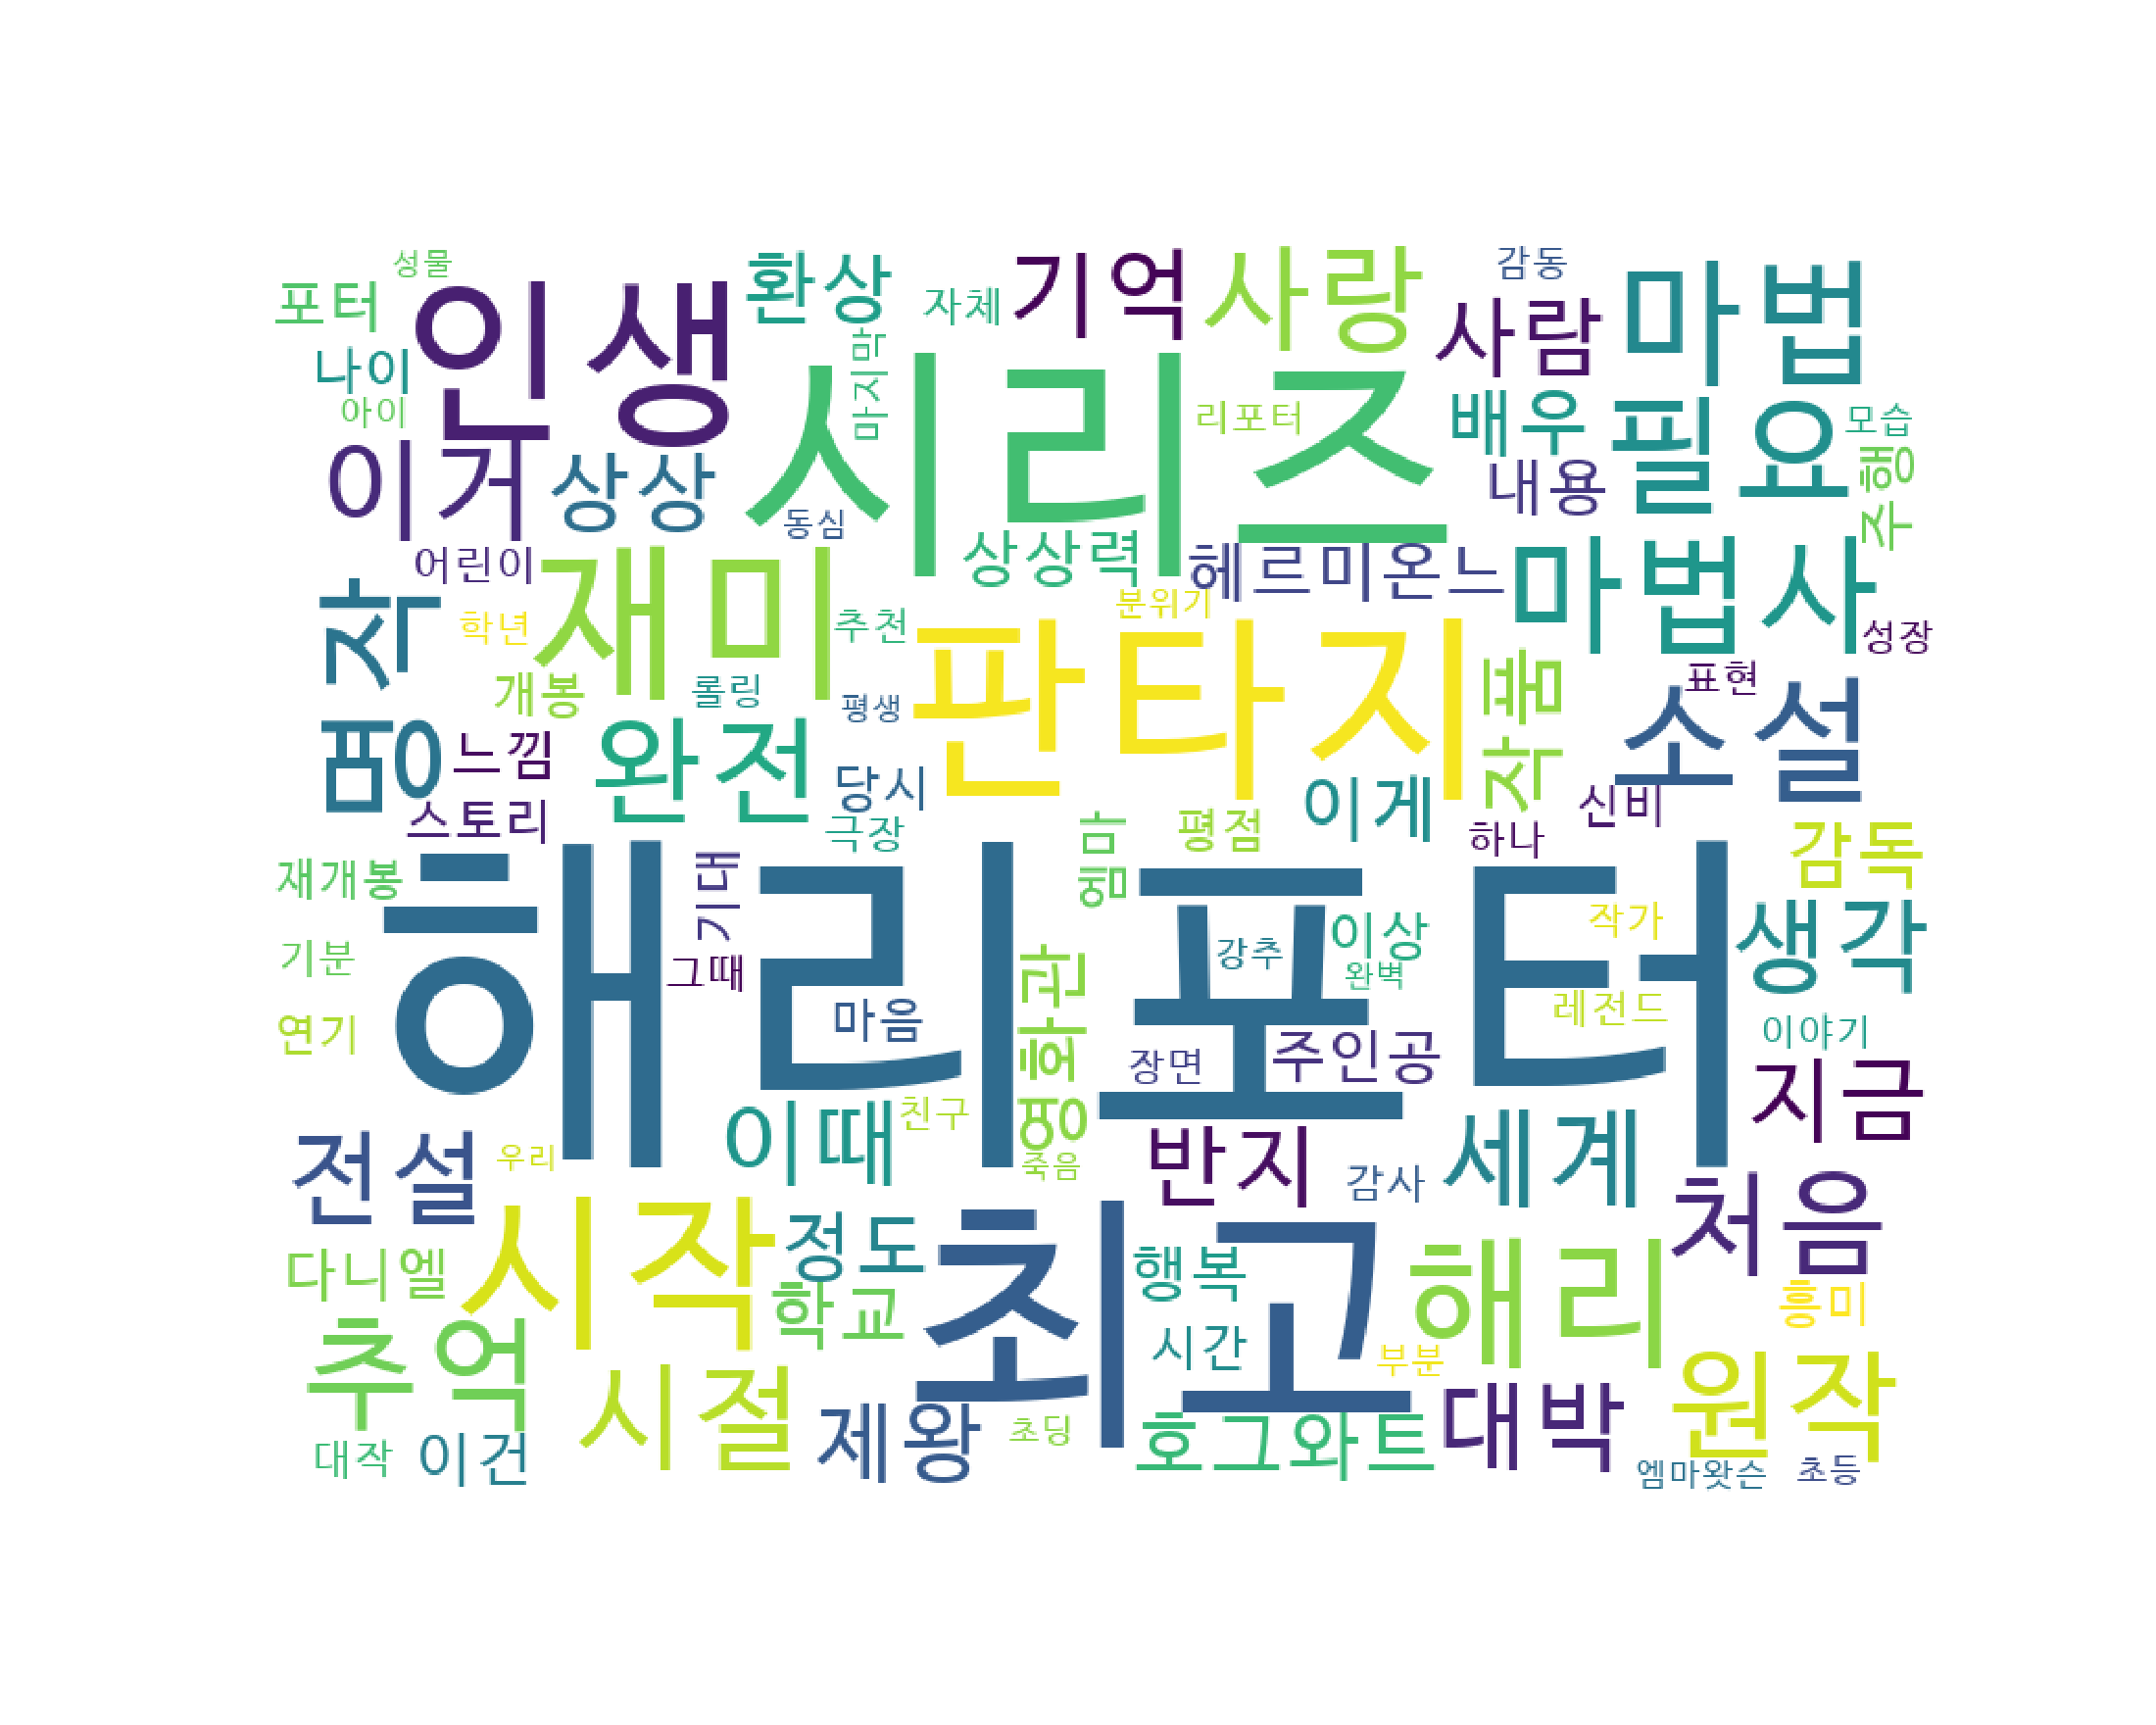

In [32]:
font_path = '/D2Coding.ttc'
# plot the WordCloud image 
wc = WordCloud(font_path=font_path, background_color='white', width=800, height=600)
cloud = wc.generate_from_frequencies(dict(tags))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)